In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

In [3]:
#Try Yahoo Finance to get data, but since the ticker X has been delisted as being acquired by another company in June 2025, we must use another way to download data.
tickers = ["X", "NUE", "STLD", "CLF", "SLX"]
start = "2020-05-31"
end = "2025-05-31"

raw = yf.download(tickers, start=start, end=end)
df = raw.stack(level=1).reset_index()
df.columns = ["Date", "Ticker", "Open", "High", "Low", "Close", "AdjClose", "Volume"]
df = df.sort_values(["Ticker", "Date"])

/var/folders/48/qvknw9ms3rz8t3mlyp0fhbch0000gn/T/ipykernel_13936/4142770092.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  raw = yf.download(tickers, start=start, end=end)
[*********************100%***********************]  5 of 5 completed

1 Failed download:
['X']: YFTzMissingError('possibly delisted; no timezone found')


In [4]:
df

,Date,Ticker,Open,High,Low,Close,AdjClose,Volume
0,2020-06-01,CLF,NaN,5.320000,5.440000,5.200000,5.220000,9019600.0
4,2020-06-02,CLF,NaN,5.600000,5.670000,5.420000,5.440000,12786000.0
8,2020-06-03,CLF,NaN,5.800000,5.920000,5.700000,5.730000,11090600.0
12,2020-06-04,CLF,NaN,5.930000,6.000000,5.730000,5.810000,11521900.0
16,2020-06-05,CLF,NaN,6.480000,6.630000,6.230000,6.300000,17168400.0
...,...,...,...,...,...,...,...,...
5007,2025-05-22,STLD,NaN,128.929169,130.805187,128.542054,130.705921,1424500.0
5011,2025-05-23,STLD,NaN,124.392982,128.164869,123.529415,126.745454,3180500.0
5015,2025-05-27,STLD,NaN,127.787682,127.837300,124.263939,125.455059,2231500.0
5019,2025-05-28,STLD,NaN,125.782623,128.145023,125.693285,128.045756,1215900.0


In [7]:
#The other way is to use alpaca
from datetime import datetime
import pandas as pd
from alpaca.data.historical import StockHistoricalDataClient
from alpaca.data.requests import StockBarsRequest, Adjustment
from alpaca.data.timeframe import TimeFrame


tickers = ["X", "NUE", "STLD", "CLF", "SLX"]

API_KEY = "PKZG3VFW4CWYJQDWKIR1"
SECRET_KEY = "bVv9zULMRjdIta6oVeGeycdbJPNUKndhJPuG8Ciw"

client = StockHistoricalDataClient(API_KEY, SECRET_KEY)

request_params = StockBarsRequest(
    symbol_or_symbols=tickers,
    timeframe=TimeFrame.Day,
    start=datetime(2020, 5, 31),
    end=datetime(2025, 5, 31),
    adjustment=Adjustment.SPLIT   # split-adjusted prices
)

df = client.get_stock_bars(request_params).df

# 3. Clean into a nice DataFrame
df = df.reset_index()  # 'timestamp' and 'symbol' become columns

df = df.rename(columns={
    "timestamp": "Date",
    "symbol": "Ticker",
    "open": "Open",
    "high": "High",
    "low": "Low",
    "close": "Close",
    "volume": "Volume"
})

# Drop timezone if present (optional but often convenient)
if pd.api.types.is_datetime64_any_dtype(df["Date"]):
    df["Date"] = df["Date"].dt.tz_localize(None)

df = df.sort_values(["Ticker", "Date"]).reset_index(drop=True)

print(df.head())


  Ticker                Date  Open    High    Low  Close      Volume  \
0    CLF 2020-06-01 04:00:00  5.22  5.4400  5.200   5.32   9456146.0   
1    CLF 2020-06-02 04:00:00  5.44  5.6650  5.420   5.60  13048674.0   
2    CLF 2020-06-03 04:00:00  5.73  5.9175  5.700   5.80  11397345.0   
3    CLF 2020-06-04 04:00:00  5.81  6.0000  5.731   5.93  11800590.0   
4    CLF 2020-06-05 04:00:00  6.30  6.6300  6.230   6.48  17559587.0   

   trade_count      vwap  
0      28353.0  5.349516  
1      40586.0  5.547176  
2      41317.0  5.793204  
3      39931.0  5.880915  
4      59964.0  6.466688  


In [9]:
# Check if each ticker has the same amount of data over five years range
df.groupby("Ticker").size()

Ticker
CLF     1257
NUE     1257
SLX     1257
STLD    1257
X       1257
dtype: int64

In [10]:
# Compute returns by ticker
df["Return"] = df.groupby("Ticker")["Close"].pct_change()

# Lagged returns
for lag in range(1, 6):
    df[f"Return_lag{lag}"] = df.groupby("Ticker")["Return"].shift(lag)

# Rolling moving averages and volatility
df["MA5"] = df.groupby("Ticker")["Close"].transform(lambda x: x.rolling(5).mean())
df["MA20"] = df.groupby("Ticker")["Close"].transform(lambda x: x.rolling(20).mean())
df["MA_diff"] = df["MA5"] - df["MA20"]

df["Vol10"] = df.groupby("Ticker")["Return"].transform(lambda x: x.rolling(10).std())

# Volume change
df["VolumeChange"] = df.groupby("Ticker")["Volume"].diff()

# Binary label: 1 = up day, 0 = down/flat
df["Direction"] = (df["Return"] > 0).astype(int)

# Drop rows with missing values induced by lags/rollings
df = df.dropna().reset_index(drop=True)

In [11]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

# Time-based split
cutoff = pd.Timestamp("2024-03-01")  # example split inside your 2020-05-31 to 2025-05-31 window

train = df[df["Date"] < cutoff]
test  = df[df["Date"] >= cutoff]

feature_cols = [
    "Return_lag1","Return_lag2","Return_lag3",
    "Return_lag4","Return_lag5",
    "MA_diff","Vol10","VolumeChange"
]

X_train, y_train = train[feature_cols], train["Direction"]
X_test,  y_test  = test[feature_cols],  test["Direction"]

tscv = TimeSeriesSplit(n_splits=5)

# Logistic Regression
log_reg = LogisticRegression(max_iter=1000)
log_grid = GridSearchCV(
    log_reg,
    {"C": [0.01, 0.1, 1, 10]},
    cv=tscv,
    scoring="accuracy"
)
log_grid.fit(X_train, y_train)
log_best = log_grid.best_estimator_

# SVM
svm = SVC()
svm_grid = GridSearchCV(
    svm,
    {"C": [0.1, 1, 10], "gamma": [0.001, 0.01, 0.1]},
    cv=tscv,
    scoring="accuracy"
)
svm_grid.fit(X_train, y_train)
svm_best = svm_grid.best_estimator_

# Random Forest
rf = RandomForestClassifier()
rf_grid = GridSearchCV(
    rf,
    {"n_estimators": [100, 200], "max_depth": [3, 5, 7]},
    cv=tscv,
    scoring="accuracy"
)
rf_grid.fit(X_train, y_train)
rf_best = rf_grid.best_estimator_

# Evaluate
models = {
    "Logistic Regression": log_best,
    "SVM": svm_best,
    "Random Forest": rf_best
}

results = {}
for name, model in models.items():
    y_pred = model.predict(X_test)
    results[name] = accuracy_score(y_test, y_pred)

print(results)

best_model_name = max(results, key=results.get)
best_model = models[best_model_name]
cm = confusion_matrix(y_test, best_model.predict(X_test))
print("Best model:", best_model_name)
print("Confusion matrix:\n", cm)


{'Logistic Regression': 0.5009584664536741, 'SVM': 0.4805111821086262, 'Random Forest': 0.5022364217252396}
Best model: Random Forest
Confusion matrix:
 [[199 614]
 [165 587]]


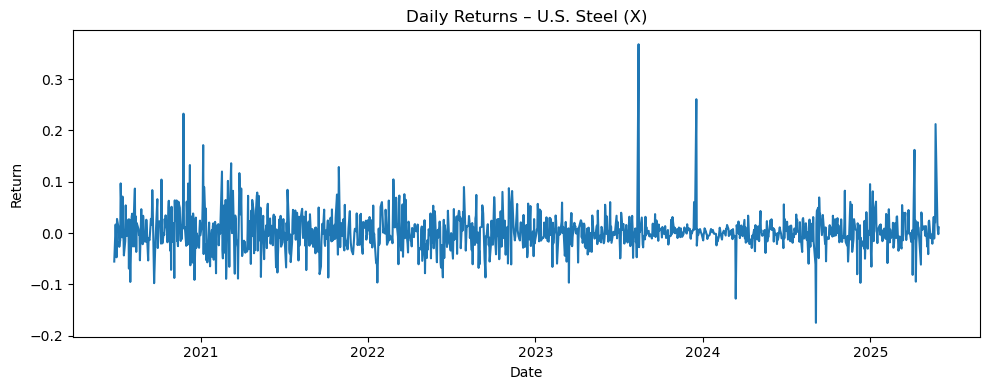

In [12]:
df_x = df[df["Ticker"] == "X"]

plt.figure(figsize=(10, 4))
plt.plot(df_x["Date"], df_x["Return"])
plt.title("Daily Returns – U.S. Steel (X)")
plt.xlabel("Date")
plt.ylabel("Return")
plt.tight_layout()
plt.show()

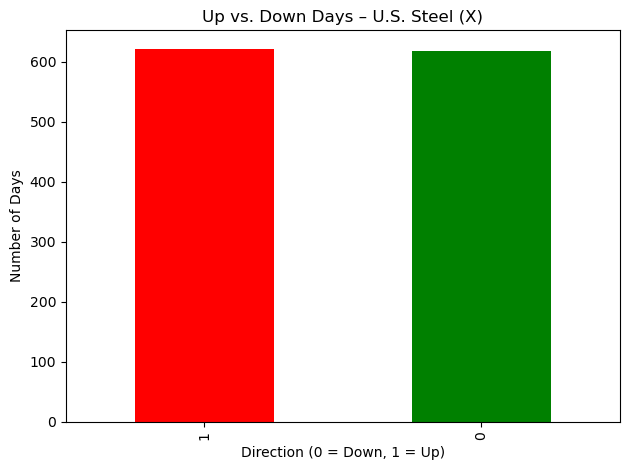

In [13]:
df_x["Direction"].value_counts().plot(kind="bar", color=["red", "green"])
plt.title("Up vs. Down Days – U.S. Steel (X)")
plt.xlabel("Direction (0 = Down, 1 = Up)")
plt.ylabel("Number of Days")
plt.tight_layout()
plt.show()